the imports we will use 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import torch.utils.tensorboard as tensorboard
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 tensor board


In [2]:
writer = SummaryWriter('runs/Res18 25Epoch')

Loading the data


In [3]:
dataset = load_dataset('ethz/food101')

understanding the enemy (our data)

In [4]:
# Inspect the dataset
print("Dataset structure:")
print(dataset)


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})


choosing to work with gpu if available 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

Preprocessing steps:

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
def collate_fn(batch):
    images = []
    labels = []
    for item in batch:
        image = item['image'].convert('RGB')  # Ensure image is in RGB format
        image = data_transforms['train'](image)  # Apply transformations
        images.append(image)
        labels.append(item['label'])
    return {
        'image': torch.stack(images),
        'label': torch.tensor(labels)
    }

In [9]:
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn),
    'validation': DataLoader(dataset['validation'], batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'validation']}
class_names = dataset['train'].features['label'].names

In [10]:
#understanding the data pt2
# Check the shapes, data types, and labels
for split in ['train', 'validation']:
    print(f"\nAnalyzing {split} split:")
    data = dataset[split]
    print(f"Number of samples: {len(data)}")
    
    # Get a sample image and label
    sample = data[0]
    image = sample['image']
    label = sample['label']
    
    print(f"Shape of sample image: {image.size}")
    print(f"Data type of sample image: {image.mode}")
    print(f"Label of sample image: {label}")


Analyzing train split:
Number of samples: 75750
Shape of sample image: (384, 512)
Data type of sample image: RGB
Label of sample image: 6

Analyzing validation split:
Number of samples: 25250
Shape of sample image: (512, 512)
Data type of sample image: RGB
Label of sample image: 6


In [11]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [12]:
def imshow(inp, title=None):
    #determining the size of our figure
    plt.figure(figsize=(64, 64)) 
    #it converts the tensor to a numpy array 3shan y-change el order beta3 el dimensions mn channel,height,width to height, width,channel 3shan y3raf y-plot it
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #bey-reverse el normalization 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title, fontsize=32)  # Adjust fontsize as needed
    
    plt.axis('off')  # Turn off axis
    plt.show()

In [13]:
batch = next(iter(dataloaders['train']))
inputs, classes = batch['image'], batch['label']

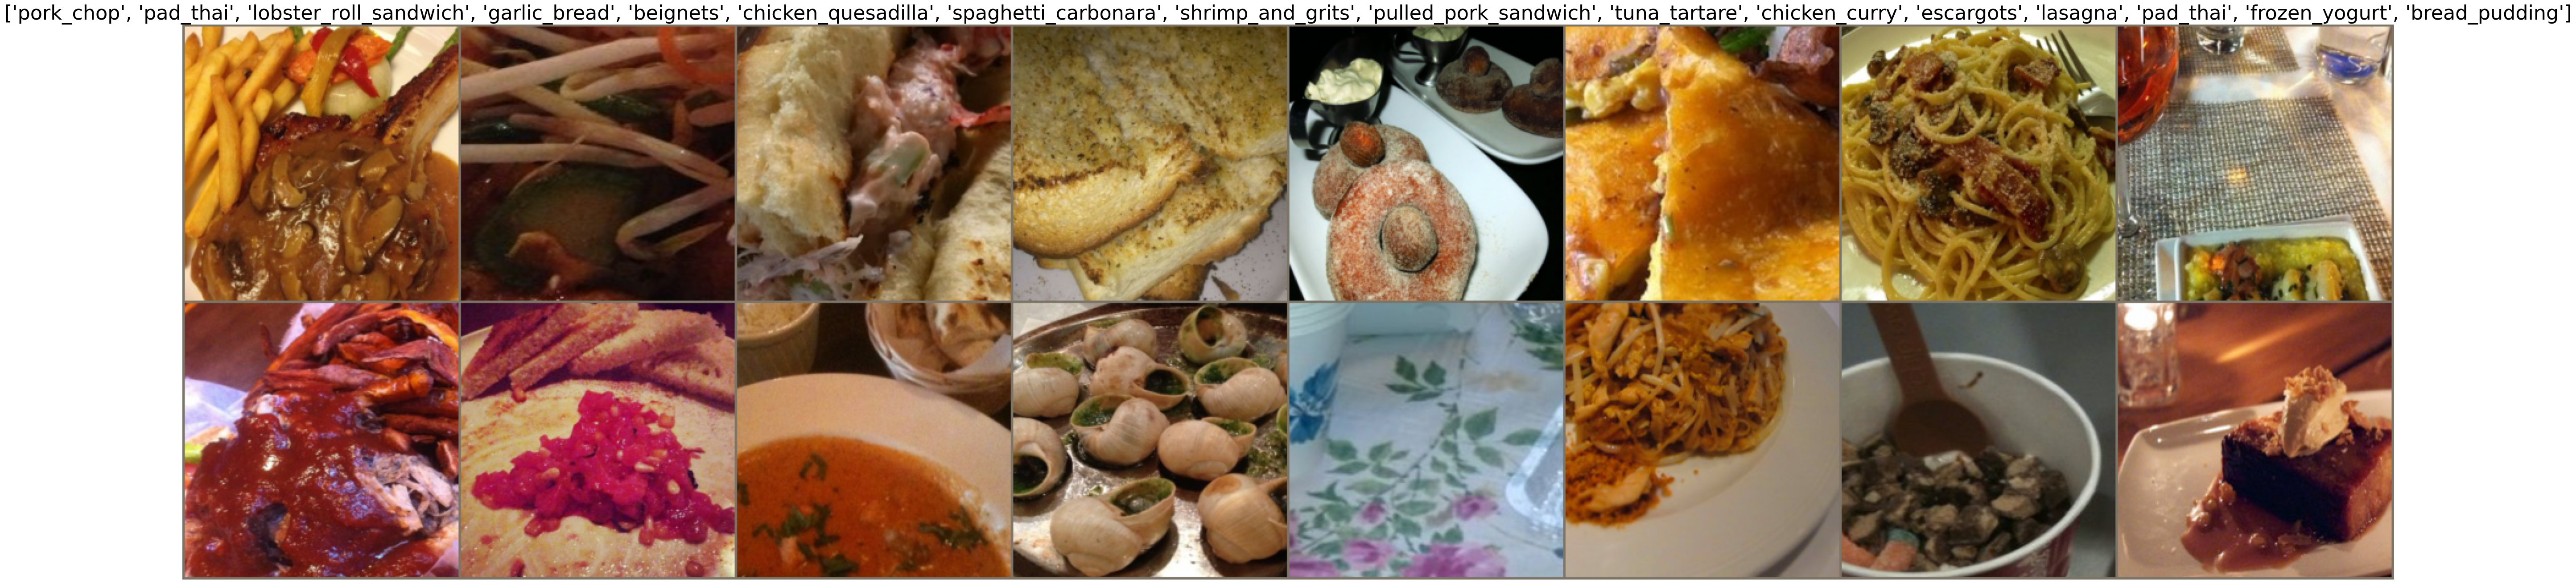

In [14]:
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train(model,criterion,optimizer,dataloaders,dataset_sizes,device):
    model.train()
    running_loss = 0.0
    corrects = 0 
    total = 0 

    for batch in tqdm(dataloaders['train']):
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = corrects / total
    
    print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return epoch_loss

In [16]:
def validate(model,dataloaders,dataset_size,criterion,device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    tp=0
    tn=0
    fp=0
    fn=0
    precision = 0.0
    recall = 0.0
    f1 = 0.0


    with torch.no_grad():
        for batch in tqdm(dataloaders['validation']):
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss/dataset_size['validation']
    accuracy = correct / total


    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    return epoch_loss, accuracy, precision, recall, f1, conf_matrix

In [17]:
model_ft = models.resnet18(weights='DEFAULT')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 101)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
def plot_confusion_matrix():
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')

  return fig

In [19]:
num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

best_f1 = 0.0
best_precision = 0.0
best_recall = 0.0
best_accuracy = 0.0

start_time = time.time()


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_loss = train(model_ft, criterion, optimizer_ft, dataloaders, dataset_sizes, device)
    val_loss, val_accuracy, precision, recall, f1, conf_matrix = validate(model_ft, dataloaders, dataset_sizes, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_f1 = f1
        best_precision = precision
        best_recall = recall

    if epoch%2==0:
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Precision/val', precision, epoch)
        writer.add_scalar('Recall/val', recall, epoch)
        writer.add_scalar('F1 Score/val', f1, epoch)
        writer.add_figure('Confusion Matrix', plot_confusion_matrix(), epoch)


end_time = time.time()
total_time = end_time - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy: {best_accuracy:.4f}')
print(f'Best Precision: {best_precision:.4f}')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best F1 Score: {best_f1:.4f}')

Epoch 1/25
----------


  1%|▍                                                                               | 26/4735 [00:03<10:51,  7.23it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:52<00:00,  7.99it/s]


Train Loss: 2.3395, Accuracy: 0.4442


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:55<00:00,  8.98it/s]


Validation Loss: 1.5174, Accuracy: 0.6080
Precision: 0.6204, Recall: 0.6080, F1 Score: 0.6013
Confusion Matrix:
[[ 56   0  18 ...   2   1  17]
 [  0 111   0 ...   2   0   4]
 [  4   0 178 ...   4   0   6]
 ...
 [  1   0   0 ... 190   0   2]
 [  1   0   1 ...   0 109   0]
 [  4   0   0 ...   6   0 182]]
Epoch 2/25
----------


 82%|████████████████████████████████████████████████████████████████              | 3888/4735 [08:11<01:44,  8.10it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:57<00:00,  7.92it/s]


Train Loss: 1.7430, Accuracy: 0.5646


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:58<00:00,  8.84it/s]


Validation Loss: 1.3254, Accuracy: 0.6563
Precision: 0.6687, Recall: 0.6563, F1 Score: 0.6510
Confusion Matrix:
[[ 74   0   7 ...   0   0  14]
 [  0 118   0 ...   0   1   0]
 [  3   0 177 ...   1   1   0]
 ...
 [  1   0   2 ... 168   0   0]
 [  0   0   0 ...   0 113   0]
 [  1   0   0 ...   0   0 200]]
Epoch 3/25
----------


 52%|████████████████████████████████████████▍                                     | 2454/4735 [05:05<04:40,  8.13it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:49<00:00,  8.04it/s]


Train Loss: 1.5821, Accuracy: 0.6025


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:58<00:00,  8.83it/s]


Validation Loss: 1.2845, Accuracy: 0.6661
Precision: 0.6762, Recall: 0.6661, F1 Score: 0.6620
Confusion Matrix:
[[ 77   0   8 ...   3   1   4]
 [  0 162   0 ...   0   0   0]
 [  4   1 190 ...   0   1   0]
 ...
 [  1   0   1 ... 167   0   0]
 [  0   1   0 ...   0 103   0]
 [  3   0   2 ...   3   0 172]]
Epoch 4/25
----------


 80%|██████████████████████████████████████████████████████████████▍               | 3792/4735 [07:53<01:57,  8.02it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:51<00:00,  8.01it/s]


Train Loss: 1.4803, Accuracy: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.81it/s]


Validation Loss: 1.2020, Accuracy: 0.6870
Precision: 0.6937, Recall: 0.6870, F1 Score: 0.6844
Confusion Matrix:
[[ 97   1   9 ...   4   0   4]
 [  0 168   0 ...   1   0   0]
 [  6   1 199 ...   0   1   1]
 ...
 [  2   0   2 ... 186   0   1]
 [  0   0   0 ...   0  86   0]
 [  2   0   0 ...   0   0 193]]
Epoch 5/25
----------


 49%|█████████████████████████████████████▉                                        | 2306/4735 [04:47<05:07,  7.90it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:51<00:00,  8.00it/s]


Train Loss: 1.4040, Accuracy: 0.6426


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.79it/s]


Validation Loss: 1.1792, Accuracy: 0.6964
Precision: 0.7062, Recall: 0.6964, F1 Score: 0.6947
Confusion Matrix:
[[101   1   9 ...   2   0   4]
 [  0 155   0 ...   1   0   0]
 [  7   3 207 ...   2   0   0]
 ...
 [  1   0   1 ... 202   0   0]
 [  0   0   1 ...   0 126   0]
 [  4   1   0 ...   1   1 178]]
Epoch 6/25
----------


  6%|█████                                                                          | 300/4735 [00:38<09:14,  7.99it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:49<00:00,  8.03it/s]


Train Loss: 1.3480, Accuracy: 0.6555


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:58<00:00,  8.83it/s]


Validation Loss: 1.1265, Accuracy: 0.7068
Precision: 0.7173, Recall: 0.7068, F1 Score: 0.7047
Confusion Matrix:
[[ 99   0  15 ...   1   0  14]
 [  0 145   1 ...   0   1   1]
 [  1   0 215 ...   0   0   0]
 ...
 [  2   0   4 ... 181   0   0]
 [  0   0   1 ...   0 145   0]
 [  3   0   1 ...   0   0 208]]
Epoch 7/25
----------


 36%|████████████████████████████▎                                                 | 1718/4735 [03:33<06:10,  8.14it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:48<00:00,  8.05it/s]


Train Loss: 1.2984, Accuracy: 0.6650


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.82it/s]


Validation Loss: 1.1087, Accuracy: 0.7113
Precision: 0.7178, Recall: 0.7113, F1 Score: 0.7097
Confusion Matrix:
[[119   0  10 ...   1   0   6]
 [  0 166   0 ...   0   0   0]
 [  8   1 206 ...   0   0   0]
 ...
 [  3   0   0 ... 174   0   1]
 [  0   0   1 ...   0 119   0]
 [  4   0   0 ...   1   0 197]]
Epoch 8/25
----------


 10%|████████▏                                                                      | 492/4735 [01:01<08:49,  8.01it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:46<00:00,  8.08it/s]


Train Loss: 1.2425, Accuracy: 0.6804


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.80it/s]


Validation Loss: 1.0955, Accuracy: 0.7140
Precision: 0.7215, Recall: 0.7140, F1 Score: 0.7117
Confusion Matrix:
[[ 71   0  24 ...   1   0  13]
 [  0 178   0 ...   0   0   0]
 [  2   0 203 ...   1   0   3]
 ...
 [  0   0   1 ... 190   0   1]
 [  0   2   0 ...   0 164   1]
 [  0   1   0 ...   0   0 211]]
Epoch 9/25
----------


 48%|█████████████████████████████████████▎                                        | 2268/4735 [04:41<05:02,  8.16it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:46<00:00,  8.07it/s]


Train Loss: 1.2105, Accuracy: 0.6873


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:58<00:00,  8.83it/s]


Validation Loss: 1.0726, Accuracy: 0.7234
Precision: 0.7280, Recall: 0.7234, F1 Score: 0.7217
Confusion Matrix:
[[120   2   7 ...   1   0   6]
 [  0 185   0 ...   0   0   1]
 [  6   0 196 ...   0   0   0]
 ...
 [  1   0   0 ... 179   1   0]
 [  0   0   0 ...   0 133   2]
 [  3   0   0 ...   0   0 194]]
Epoch 10/25
----------


 88%|████████████████████████████████████████████████████████████████████▌         | 4159/4735 [08:36<01:10,  8.17it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:49<00:00,  8.04it/s]


Train Loss: 1.1708, Accuracy: 0.6949


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.79it/s]


Validation Loss: 1.0504, Accuracy: 0.7241
Precision: 0.7327, Recall: 0.7241, F1 Score: 0.7242
Confusion Matrix:
[[121   1   6 ...   2   0   6]
 [  0 164   0 ...   0   0   0]
 [  8   0 204 ...   0   0   0]
 ...
 [  3   0   0 ... 184   0   0]
 [  0   0   0 ...   0 123   1]
 [  1   1   0 ...   0   0 213]]
Epoch 11/25
----------


  2%|█▍                                                                              | 88/4735 [00:11<09:38,  8.03it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:52<00:00,  8.00it/s]


Train Loss: 1.1413, Accuracy: 0.7023


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.78it/s]


Validation Loss: 1.0728, Accuracy: 0.7244
Precision: 0.7340, Recall: 0.7244, F1 Score: 0.7231
Confusion Matrix:
[[114   1   5 ...   2   0   9]
 [  0 157   1 ...   0   0   0]
 [  6   0 208 ...   0   0   1]
 ...
 [  0   0   1 ... 195   0   0]
 [  0   1   1 ...   0 146   0]
 [  1   0   0 ...   0   0 201]]
Epoch 12/25
----------


 27%|████████████████████▉                                                         | 1272/4735 [02:39<07:04,  8.15it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:53<00:00,  7.98it/s]


Train Loss: 1.1055, Accuracy: 0.7114


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.82it/s]


Validation Loss: 1.0739, Accuracy: 0.7215
Precision: 0.7308, Recall: 0.7215, F1 Score: 0.7209
Confusion Matrix:
[[112   2   4 ...   2   0   8]
 [  0 195   0 ...   0   0   0]
 [  9   0 203 ...   2   0   1]
 ...
 [  4   0   0 ... 180   0   0]
 [  0   0   1 ...   0 143   0]
 [  3   1   2 ...   1   0 193]]
Epoch 13/25
----------


 59%|██████████████████████████████████████████████▏                               | 2806/4735 [05:49<03:58,  8.07it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:51<00:00,  8.01it/s]


Train Loss: 1.0847, Accuracy: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.78it/s]


Validation Loss: 1.0434, Accuracy: 0.7326
Precision: 0.7380, Recall: 0.7326, F1 Score: 0.7310
Confusion Matrix:
[[117   1   1 ...   3   0   6]
 [  0 202   1 ...   0   0   1]
 [  7   0 204 ...   1   2   0]
 ...
 [  0   0   0 ... 202   0   0]
 [  0   2   0 ...   0 139   0]
 [  3   0   0 ...   0   0 199]]
Epoch 14/25
----------


 10%|███████▊                                                                       | 472/4735 [00:59<08:46,  8.10it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:52<00:00,  7.99it/s]


Train Loss: 1.0571, Accuracy: 0.7224


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.81it/s]


Validation Loss: 1.0376, Accuracy: 0.7305
Precision: 0.7384, Recall: 0.7305, F1 Score: 0.7293
Confusion Matrix:
[[124   0   8 ...   0   0   8]
 [  0 156   1 ...   1   0   0]
 [  6   0 210 ...   2   1   0]
 ...
 [  0   0   2 ... 194   0   0]
 [  0   0   0 ...   1 137   0]
 [  4   0   0 ...   0   0 214]]
Epoch 15/25
----------


 81%|███████████████████████████████████████████████████████████████▍              | 3849/4735 [08:00<01:48,  8.19it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:51<00:00,  8.01it/s]


Train Loss: 1.0349, Accuracy: 0.7299


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.78it/s]


Validation Loss: 1.0407, Accuracy: 0.7313
Precision: 0.7379, Recall: 0.7313, F1 Score: 0.7298
Confusion Matrix:
[[111   1   6 ...   2   1   7]
 [  0 162   0 ...   1   1   0]
 [  5   0 201 ...   2   1   0]
 ...
 [  0   0   0 ... 189   1   0]
 [  1   0   0 ...   0 136   1]
 [  0   0   0 ...   0   0 211]]
Epoch 16/25
----------


 17%|█████████████▋                                                                 | 822/4735 [01:42<08:09,  8.00it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:52<00:00,  7.99it/s]


Train Loss: 1.0177, Accuracy: 0.7305


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.78it/s]


Validation Loss: 1.0400, Accuracy: 0.7333
Precision: 0.7402, Recall: 0.7333, F1 Score: 0.7328
Confusion Matrix:
[[153   0   2 ...   2   1   2]
 [  0 168   0 ...   0   0   1]
 [ 13   0 198 ...   1   0   1]
 ...
 [  2   0   0 ... 199   0   0]
 [  0   0   0 ...   1 145   0]
 [  1   0   1 ...   0   0 200]]
Epoch 17/25
----------


 39%|██████████████████████████████▏                                               | 1835/4735 [03:50<06:00,  8.04it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:53<00:00,  7.98it/s]


Train Loss: 0.9978, Accuracy: 0.7375


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:00<00:00,  8.77it/s]


Validation Loss: 1.0646, Accuracy: 0.7273
Precision: 0.7329, Recall: 0.7273, F1 Score: 0.7260
Confusion Matrix:
[[105   0   4 ...   3   0   7]
 [  0 187   0 ...   0   0   1]
 [  5   0 200 ...   2   0   0]
 ...
 [  3   0   0 ... 174   0   0]
 [  0   0   0 ...   0 162   0]
 [  3   0   0 ...   0   0 204]]
Epoch 18/25
----------


 75%|██████████████████████████████████████████████████████████▏                   | 3532/4735 [07:22<02:29,  8.03it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:53<00:00,  7.97it/s]


Train Loss: 0.9644, Accuracy: 0.7468


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:01<00:00,  8.72it/s]


Validation Loss: 1.0499, Accuracy: 0.7305
Precision: 0.7379, Recall: 0.7305, F1 Score: 0.7298
Confusion Matrix:
[[115   1   7 ...   8   0  10]
 [  0 181   0 ...   1   0   0]
 [  3   1 204 ...   1   0   0]
 ...
 [  1   0   2 ... 190   0   0]
 [  0   0   0 ...   0 142   0]
 [  2   1   0 ...   0   0 190]]
Epoch 19/25
----------


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4472/4735 [09:20<00:33,  7.93it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:53<00:00,  7.98it/s]


Train Loss: 0.9563, Accuracy: 0.7484


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [02:59<00:00,  8.77it/s]


Validation Loss: 1.0272, Accuracy: 0.7389
Precision: 0.7458, Recall: 0.7389, F1 Score: 0.7386
Confusion Matrix:
[[111   0  10 ...   5   0   8]
 [  0 143   0 ...   0   0   1]
 [  7   0 207 ...   2   2   0]
 ...
 [  1   0   1 ... 178   0   1]
 [  0   0   1 ...   0 161   0]
 [  3   0   0 ...   0   0 208]]
Epoch 20/25
----------


 28%|█████████████████████▉                                                        | 1331/4735 [02:47<07:03,  8.04it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:54<00:00,  7.96it/s]


Train Loss: 0.9364, Accuracy: 0.7516


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:01<00:00,  8.72it/s]


Validation Loss: 1.0436, Accuracy: 0.7326
Precision: 0.7420, Recall: 0.7326, F1 Score: 0.7325
Confusion Matrix:
[[134   0  11 ...   1   0   4]
 [  0 167   0 ...   0   0   1]
 [  6   0 213 ...   1   0   1]
 ...
 [  0   0   2 ... 181   0   0]
 [  0   0   0 ...   0 149   0]
 [  1   0   0 ...   1   0 201]]
Epoch 21/25
----------


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4512/4735 [09:27<00:28,  7.95it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:55<00:00,  7.96it/s]


Train Loss: 0.9163, Accuracy: 0.7566


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:01<00:00,  8.71it/s]


Validation Loss: 1.0502, Accuracy: 0.7341
Precision: 0.7416, Recall: 0.7341, F1 Score: 0.7324
Confusion Matrix:
[[115   1   4 ...   1   1  12]
 [  0 191   0 ...   0   1   1]
 [  4   0 200 ...   2   1   1]
 ...
 [  3   0   0 ... 197   0   0]
 [  0   0   0 ...   0 160   0]
 [  2   0   0 ...   1   0 210]]
Epoch 22/25
----------


  6%|████▍                                                                          | 267/4735 [00:33<09:22,  7.95it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [09:57<00:00,  7.92it/s]


Train Loss: 0.9077, Accuracy: 0.7576


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:02<00:00,  8.67it/s]


Validation Loss: 1.0317, Accuracy: 0.7386
Precision: 0.7475, Recall: 0.7386, F1 Score: 0.7388
Confusion Matrix:
[[132   0   5 ...   2   0   4]
 [  0 152   0 ...   0   0   0]
 [ 12   0 213 ...   0   0   0]
 ...
 [  4   0   0 ... 189   0   1]
 [  0   0   0 ...   0 135   0]
 [  3   1   0 ...   1   0 200]]
Epoch 23/25
----------


 93%|████████████████████████████████████████████████████████████████████████▊     | 4423/4735 [09:24<00:39,  7.89it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [10:03<00:00,  7.84it/s]


Train Loss: 0.8830, Accuracy: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:02<00:00,  8.65it/s]


Validation Loss: 1.0428, Accuracy: 0.7387
Precision: 0.7456, Recall: 0.7387, F1 Score: 0.7378
Confusion Matrix:
[[150   1   5 ...   1   0   9]
 [  0 181   0 ...   0   0   1]
 [ 13   1 207 ...   0   0   2]
 ...
 [  5   0   0 ... 185   0   2]
 [  0   0   0 ...   0 147   0]
 [  4   0   1 ...   0   0 211]]
Epoch 24/25
----------


 44%|██████████████████████████████████                                            | 2071/4735 [04:22<05:36,  7.92it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [10:01<00:00,  7.88it/s]


Train Loss: 0.8782, Accuracy: 0.7663


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:01<00:00,  8.68it/s]


Validation Loss: 1.0342, Accuracy: 0.7389
Precision: 0.7412, Recall: 0.7389, F1 Score: 0.7368
Confusion Matrix:
[[127   0   2 ...   4   1   9]
 [  1 180   1 ...   0   0   1]
 [  8   1 208 ...   1   0   0]
 ...
 [  2   1   0 ... 186   0   0]
 [  0   2   0 ...   0 150   0]
 [  2   0   1 ...   0   0 203]]
Epoch 25/25
----------


 50%|███████████████████████████████████████▎                                      | 2385/4735 [05:03<05:01,  7.80it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [10:02<00:00,  7.86it/s]


Train Loss: 0.8546, Accuracy: 0.7714


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:02<00:00,  8.65it/s]


Validation Loss: 1.0447, Accuracy: 0.7349
Precision: 0.7421, Recall: 0.7349, F1 Score: 0.7342
Confusion Matrix:
[[133   1   5 ...   2   0   2]
 [  0 176   0 ...   0   1   0]
 [  6   0 208 ...   2   0   0]
 ...
 [  2   0   0 ... 187   0   0]
 [  0   1   0 ...   0 155   0]
 [  4   1   0 ...   5   0 191]]
Training complete in 323m 24s
Best Validation Accuracy: 0.7389
Best Precision: 0.7458
Best Recall: 0.7389
Best F1 Score: 0.7386


In [20]:
torch.save(model_ft.state_dict(), 'modelResnetAdam.pth')